<a href="https://colab.research.google.com/github/DanielGregory/DataAnalysis/blob/main/Data_Analysis_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y jags

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  jags
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,644 kB of archives.
After this operation, 3,492 kB of additional disk space will be used.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ jags 4.3.2-1.2204.0 [1,644 kB]
Fetched 1,644 kB in 0s (6,767 kB/s)
Selecting previously unselected package jags.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../jags_4.3.2-1.2204.0_amd64.deb ...
Unpacking jags (4.3.2-1.2204.0) ...
Setting up jags (4.3.2-1.2204.0) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
# Load required libraries
install.packages("rjags", repos="http://cran.rstudio.com")
library(rjags)
library(coda)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.rstudio.com/src/contrib/rjags_4-17.tar.gz'
Content type 'application/x-gzip' length 76394 bytes (74 KB)
downloaded 74 KB


The downloaded source packages are in
	‘/tmp/RtmpbMqBWe/downloaded_packages’


In [ ]:
%%R
# Load the dataset
data <- read.csv("launches.csv")

In [ ]:
%%R
# Center and rescale SinceFirst
data <- data %>%
  mutate(SinceFirst_scaled = (SinceFirst - mean(SinceFirst, na.rm = TRUE)) / (2 * sd(SinceFirst, na.rm = TRUE)))


In [ ]:
%%R
# Prepare data for JAGS
data_jags <- list(
  y = data$Success,
  x = data$SinceFirst_scaled,
  N = nrow(data)
)

In [ ]:
%%R
# Write model to a file
model_string <- "
model {
  for (i in 1:N) {
    y[i] ~ dbern(p[i])
    logit(p[i]) <- beta0 + beta1 * x[i]
  }
  beta0 ~ dt(0, pow(1/10, 2), 1)
  beta1 ~ dt(0, pow(1/2.5, 2), 1)
}
"
writeLines(model_string, "model.bug")

In [ ]:
%%R
# Initialize and run the model
model <- jags.model("model.bug", data = data_jags, n.chains = 3, n.adapt = 1000)

# Burn-in
update(model, n.iter = 2000)

# Sample from posterior
samples <- coda.samples(model,
                        variable.names = c("beta0", "beta1"),
                        n.iter = 5000, thin =3)

# Combine chains
posterior <- as.mcmc(do.call(rbind, samples))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 380
   Unobserved stochastic nodes: 2
   Total graph size: 1783

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%
  |**************************************************| 100%


In [ ]:
%%R
# Summary
summary_stats <- summary(samples)
ess_value <- effectiveSize(samples)
print(summary_stats)
print(ess_value)


Iterations = 3003:7998
Thinning interval = 3 
Number of chains = 3 
Sample size per chain = 1666 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
beta0 1.860 0.1634 0.002312       0.002540
beta1 1.374 0.4284 0.006060       0.006613

2. Quantiles for each variable:

        2.5%   25%   50%   75% 97.5%
beta0 1.5532 1.745 1.853 1.968 2.198
beta1 0.5932 1.074 1.352 1.650 2.252

   beta0    beta1 
4142.470 4200.885 


In [ ]:
%%R
# Posterior P(beta1 > 0)
prob_positive_beta1 <- mean(posterior[, "beta1"] > 0)
cat("Posterior P(beta1 > 0):", prob_positive_beta1, "\n")


Posterior P(beta1 > 0): 1 


In [ ]:
%%R
# Prob of success on first attempt (x = 0)
p_first <- 1 / (1 + exp(-posterior[, "beta0"]))
cred_interval <- quantile(p_first, probs = c(0.025, 0.975))
cat("95% CI for success on first attempt:", cred_interval, "\n")

95% CI for success on first attempt: 0.8253687 0.900029 


In [ ]:
%%R
# (f) DIC
dic_result <- dic.samples(model, n.iter = 5000)
print(dic_result)

  |**************************************************| 100%
Mean deviance:  313.4 
penalty 1.993 
Penalized deviance: 315.4 


In [ ]:
%%R
# Preprocess the data
data2 <- data %>%
  mutate(
    SinceFirst_scaled = (SinceFirst - mean(SinceFirst)) / (2 * sd(SinceFirst)),
    VehicleID = as.integer(factor(Vehicle))  # Convert vehicle to integer index
  )


In [ ]:
%%R
# Prepare data for JAGS
data_jags_2 <- list(
  y = data2$Success,
  x = data2$SinceFirst_scaled,
  vehicle = data2$VehicleID,
  N = nrow(data2),
  J = length(unique(data2$VehicleID))
)

In [ ]:
%%R
#  Write JAGS model to file
cat("
model {
  for (i in 1:N) {
    y[i] ~ dbern(p[i])
    logit(p[i]) <- alpha + beta * x[i] + vehicle_effect[vehicle[i]]
  }
  #priors for fixed effects
  alpha ~ dt(0, 1 / (10^2), 1)
  beta ~ dt(0, 1 / (2.5^2), 1)

  #random effects for vehicle type
  for (j in 1:J) {
    vehicle_effect[j] ~ dnorm(0, tau_vehicle)
  }
  #hyperparameter for standard deviation
  tau_vehicle <- 1 / (sigma_vehicle^2)
  sigma_vehicle ~ dunif(0, 10)
}
", file = "model2.txt")

In [ ]:
%%R
#  Run the model
set.seed(123)
model <- jags.model("model2.txt", data = data_jags_2, n.chains = 3, n.adapt = 1000)

update(model, 5000)  # Burn-in

samples2 <- coda.samples(model,
                        variable.names = c("alpha", "beta", "sigma_vehicle", "vehicle_effect"),
                        n.iter = 10000, thin = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 380
   Unobserved stochastic nodes: 38
   Total graph size: 2286

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%
  |**************************************************| 100%


In [ ]:
%%R
# Posterior summary
summary_stats <- summary(samples2)
ess_value <- effectiveSize(samples2)

posterior_mean_sd <- summary_stats$statistics
posterior_CI <- summary_stats$quantiles[, c("2.5%", "97.5%")]
print(summary_stats)
print(posterior_mean_sd[c("alpha", "beta", "sigma_vehicle"), ])
print(posterior_CI[c("alpha", "beta", "sigma_vehicle"), ])
print(ess_value)



Iterations = 6003:15999
Thinning interval = 3 
Number of chains = 3 
Sample size per chain = 3333 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                       Mean     SD Naive SE Time-series SE
alpha               1.68379 0.3147 0.003148       0.006279
beta                1.06353 0.4729 0.004729       0.006265
sigma_vehicle       1.28269 0.3664 0.003664       0.009058
vehicle_effect[1]  -1.50043 0.7663 0.007664       0.010841
vehicle_effect[2]   1.09367 0.7657 0.007658       0.009641
vehicle_effect[3]  -0.93869 0.9587 0.009588       0.012598
vehicle_effect[4]   1.02974 0.5341 0.005341       0.007423
vehicle_effect[5]   0.18197 0.8679 0.008679       0.009758
vehicle_effect[6]  -1.03726 0.8131 0.008131       0.010627
vehicle_effect[7]  -1.15995 0.7315 0.007316       0.009509
vehicle_effect[8]   0.41063 1.1893 0.011894       0.013349
vehicle_effect[9]   1.04561 1.0712 0.010713       0.014027
vehicle_effect[10]  0.32179 0.8457 

In [ ]:
%%R
# Load devtools
library(devtools)

#Install the package using devtools
devtools::install_github("stan-dev/bayesplot")

# Load bayesplot
library(bayesplot)

Skipping install of 'bayesplot' from a github remote, the SHA1 (23e00b5d) has not changed since last install.
  Use `force = TRUE` to force installation


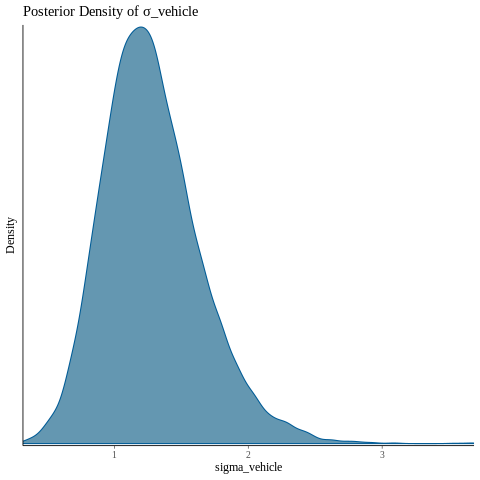

In [ ]:
%%R
# Convert MCMC samples to matrix
samples_matrix <- as.matrix(samples2)

# Plot density for sigma_vehicle
mcmc_dens(samples_matrix, pars = "sigma_vehicle")+
  ylab("Density") +
  ggtitle("Posterior Density of σ_vehicle")


In [ ]:
%%R
#  DIC
dic_val <- dic.samples(model, n.iter = 5000, type = "pD")
print(dic_val)


  |**************************************************| 100%
Mean deviance:  270.5 
penalty 20.54 
Penalized deviance: 291.1 


In [ ]:
%%R
#  Most reliable vehicle analysis
vehicle_effect_samples <- as.matrix(samples2)[, grep("vehicle_effect\\[", colnames(as.matrix(samples2)))]
most_reliable_vehicle_index <- apply(vehicle_effect_samples, 1, which.max)
vehicle_counts <- table(most_reliable_vehicle_index)
most_likely_vehicle <- as.integer(names(which.max(vehicle_counts)))
posterior_prob_most_reliable <- max(vehicle_counts) / sum(vehicle_counts)

vehicle_name <- levels(factor(data2$Vehicle))[most_likely_vehicle]
cat("\nMost reliable vehicle type:", vehicle_name, "\n")
cat("Posterior probability it is most reliable:", round(posterior_prob_most_reliable, 3), "\n")


Most reliable vehicle type: Long March 6 
Posterior probability it is most reliable: 0.21 
